## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import _tree
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import xgboost as xgb

### (a) Obtain Data

Get the Accute Inamations Data Set

In [2]:
# Setting the relative path and file name
path = "../Data/"
file_name = "diagnosis.data"

# Construct the full path
full_path = path + file_name

# Reading the data from the file
# The data is tab-separated and has no headers, as per the information provided
data = pd.read_csv(full_path, delimiter='\t', header=None, encoding='UTF-16')

# Naming the columns for better understanding
column_names = [
    "Temperature_of_patient",
    "Occurrence_of_nausea",
    "Lumbar_pain",
    "Urine_pushing",
    "Micturition_pains",
    "Burning_of_urethra",
    "Inflammation_of_urinary_bladder",
    "Nephritis_of_renal_pelvis_origin"
]
data.columns = column_names

# Display the first few rows of the dataset to verify
print(data.head())

  Temperature_of_patient Occurrence_of_nausea Lumbar_pain Urine_pushing  \
0                   35,5                   no         yes            no   
1                   35,9                   no          no           yes   
2                   35,9                   no         yes            no   
3                   36,0                   no          no           yes   
4                   36,0                   no         yes            no   

  Micturition_pains Burning_of_urethra Inflammation_of_urinary_bladder  \
0                no                 no                              no   
1               yes                yes                             yes   
2                no                 no                              no   
3               yes                yes                             yes   
4                no                 no                              no   

  Nephritis_of_renal_pelvis_origin  
0                               no  
1                             

### (b) Build a decision tree

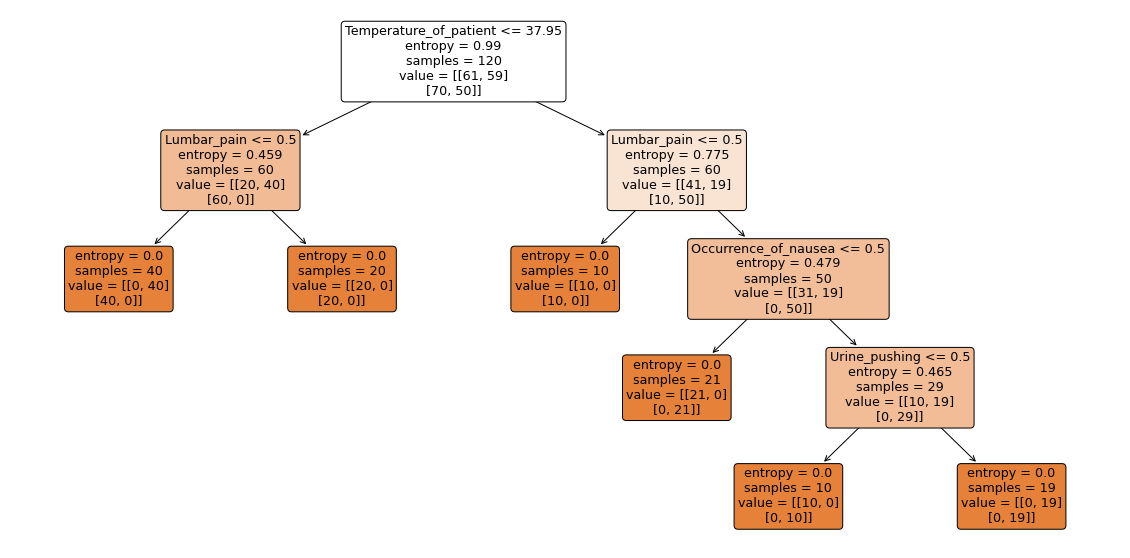

In [3]:
# Convert comma-separated float values to dot-separated (if required)
if 'Temperature_of_patient' in data.columns:
    if data['Temperature_of_patient'].dtype == 'O':  # Check if the column datatype is Object (String)
        data['Temperature_of_patient'] = data['Temperature_of_patient'].str.replace(',', '.').astype(float)

# Convert 'yes' and 'no' values to 1 and 0
binary_cols = ['Occurrence_of_nausea', 'Lumbar_pain', 'Urine_pushing', 'Micturition_pains', 'Burning_of_urethra']
for col in binary_cols:
    data[col] = data[col].map({'yes': 1, 'no': 0})

# Split the data into features and targets
X = data.drop(columns=['Inflammation_of_urinary_bladder', 'Nephritis_of_renal_pelvis_origin'])
y = data[['Inflammation_of_urinary_bladder', 'Nephritis_of_renal_pelvis_origin']]

# Build the decision tree
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=y.columns.to_list(), rounded=True)
plt.show()

### (c) Convert the decision rules

In [4]:
def tree_to_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    rules_list = []

    def recurse(node, previous_rules):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], previous_rules + ["{} <= {}".format(name, threshold)])
            recurse(tree_.children_right[node], previous_rules + ["{} > {}".format(name, threshold)])
        else:
            # At this point, we're at a leaf node. Let's extract the decision at this leaf node.
            label = np.argmax(tree_.value[node])
            rules_list.append("IF {} THEN class = {}".format(" AND ".join(previous_rules), label))
    
    recurse(0, [])
    return rules_list

# Extract rules
rules = tree_to_rules(clf, X.columns)
for rule in rules:
    print(rule)

IF Temperature_of_patient <= 37.95000076293945 AND Lumbar_pain <= 0.5 THEN class = 1
IF Temperature_of_patient <= 37.95000076293945 AND Lumbar_pain > 0.5 THEN class = 0
IF Temperature_of_patient > 37.95000076293945 AND Lumbar_pain <= 0.5 THEN class = 0
IF Temperature_of_patient > 37.95000076293945 AND Lumbar_pain > 0.5 AND Occurrence_of_nausea <= 0.5 THEN class = 0
IF Temperature_of_patient > 37.95000076293945 AND Lumbar_pain > 0.5 AND Occurrence_of_nausea > 0.5 AND Urine_pushing <= 0.5 THEN class = 0
IF Temperature_of_patient > 37.95000076293945 AND Lumbar_pain > 0.5 AND Occurrence_of_nausea > 0.5 AND Urine_pushing > 0.5 THEN class = 1


### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

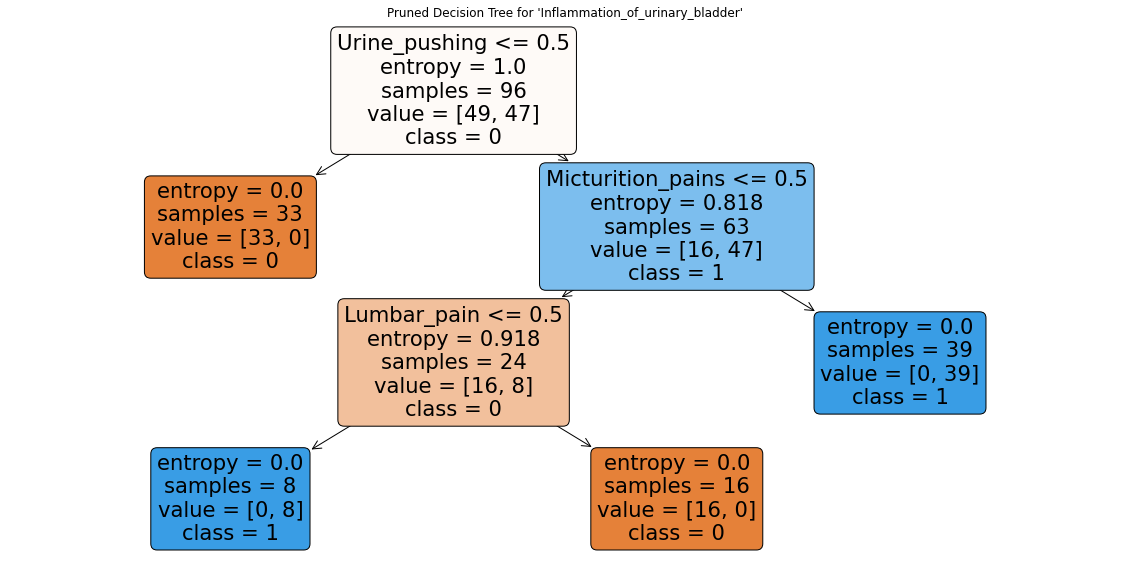

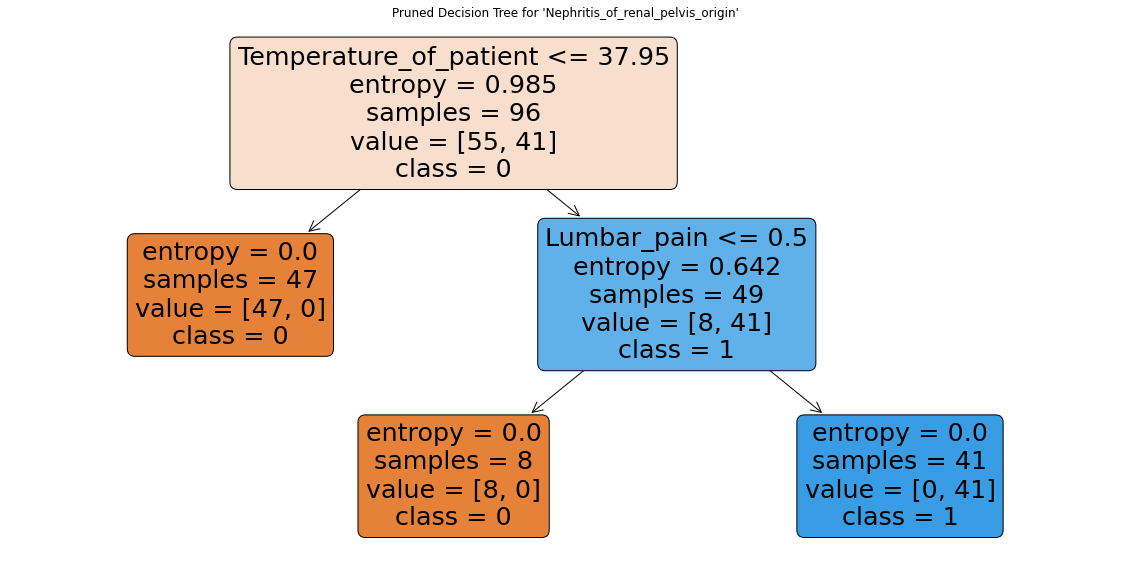

In [5]:
# Split data and train for 'Inflammation_of_urinary_bladder'
y1 = data['Inflammation_of_urinary_bladder']
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)

# Train the initial tree for y1
clf1 = DecisionTreeClassifier(random_state=0, criterion='entropy')
clf1.fit(X_train, y1_train)

# Perform cost-complexity pruning for y1
path1 = clf1.cost_complexity_pruning_path(X_train, y1_train)
ccp_alphas, impurities = path1.ccp_alphas, path1.impurities

clf1_dts = [DecisionTreeClassifier(random_state=0, ccp_alpha=alpha, criterion='entropy').fit(X_train, y1_train) for alpha in ccp_alphas]
scores1 = [clf1_dt.score(X_test, y1_test) for clf1_dt in clf1_dts]
best_alpha1 = ccp_alphas[scores1.index(max(scores1))]

# Train a pruned tree for y1 using the best alpha
clf1_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha1, criterion='entropy')
clf1_pruned.fit(X_train, y1_train)

# Visualize the pruned tree for y1
plt.figure(figsize=(20, 10))
plot_tree(clf1_pruned, filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True)
plt.title("Pruned Decision Tree for 'Inflammation_of_urinary_bladder'")
plt.show()

# Split data and train for 'Nephritis_of_renal_pelvis_origin'
y2 = data['Nephritis_of_renal_pelvis_origin']
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

# Train the initial tree for y2
clf2 = DecisionTreeClassifier(random_state=0, criterion='entropy')
clf2.fit(X_train, y2_train)

# Perform cost-complexity pruning for y2
path2 = clf2.cost_complexity_pruning_path(X_train, y2_train)
ccp_alphas, impurities = path2.ccp_alphas, path2.impurities

clf2_dts = [DecisionTreeClassifier(random_state=0, ccp_alpha=alpha, criterion='entropy').fit(X_train, y2_train) for alpha in ccp_alphas]
scores2 = [clf2_dt.score(X_test, y2_test) for clf2_dt in clf2_dts]
best_alpha2 = ccp_alphas[scores2.index(max(scores2))]

# Train a pruned tree for y2 using the best alpha
clf2_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha2, criterion='entropy')
clf2_pruned.fit(X_train, y2_train)

# Visualize the pruned tree for y2
plt.figure(figsize=(20, 10))
plot_tree(clf2_pruned, filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True)
plt.title("Pruned Decision Tree for 'Nephritis_of_renal_pelvis_origin'")
plt.show()

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [6]:
# # Setting the relative path and file name
# path = "../Data/"
# file_name = "communities.data"

# # Construct the full path
# full_path = path + file_name

# # Reading the data considering it as comma-separated
# data_communities = pd.read_csv(full_path, delimiter=',', header=None, encoding='UTF-8')

# # Display the first few rows to verify
# print(data_communities.head())

# Setting the relative path and file name
path = "../Data/"
file_name = "communities.data"

# Construct the full path
full_path = path + file_name

# The attribute names for the communities dataset as provided earlier
column_names = [
    "state", "county", "community", "communityname", "fold", "population", "householdsize", 
    "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp", "agePct12t21", 
    "agePct12t29", "agePct16t24", "agePct65up", "numbUrban", "pctUrban", 
    "medIncome", "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec", 
    "pctWPubAsst", "pctWRetire", "medFamInc", "perCapInc", "whitePerCap", 
    "blackPerCap", "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", 
    "NumUnderPov", "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", 
    "PctBSorMore", "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ", 
    "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", 
    "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par", 
    "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", 
    "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5", 
    "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5", 
    "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell", 
    "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", "PersPerOwnOccHous", 
    "PersPerRentOccHous", "PctPersOwnOccup", "PctPersDenseHous", "PctHousLess3BR", 
    "MedNumBR", "HousVacant", "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", 
    "PctVacMore6Mos", "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", 
    "OwnOccLowQuart", "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", 
    "RentHighQ", "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", 
    "MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", "PctForeignBorn", 
    "PctBornSameState", "PctSameHouse85", "PctSameCity85", "PctSameState85", 
    "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop", 
    "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop", 
    "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp", 
    "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", 
    "PolicAveOTWorked", "LandArea", "PopDens", "PctUsePubTrans", "PolicCars", 
    "PolicOperBudg", "LemasPctPolicOnPatr", "LemasGangUnitDeploy", 
    "LemasPctOfficDrugUn", "PolicBudgPerPop", "ViolentCrimesPerPop"
]

# Reading the data considering it as comma-separated
data_communities = pd.read_csv(full_path, delimiter=',', header=None, encoding='UTF-8', names=column_names)

# Display the first few rows to verify
print(data_communities.head())

   state county community        communityname  fold  population  \
0      8      ?         ?         Lakewoodcity     1        0.19   
1     53      ?         ?          Tukwilacity     1        0.00   
2     24      ?         ?         Aberdeentown     1        0.00   
3     34      5     81440  Willingborotownship     1        0.04   
4     42     95      6096    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20       0.06           0.0

### (b) Missing values

In [7]:
# Step 1: Removing non-predictive features
non_predictive_features = ['state', 'county', 'community', 'communityname', 'fold']
data_communities.drop(columns=non_predictive_features, inplace=True)

# Step 2: Replacing '?' with np.nan
data_communities.replace('?', np.nan, inplace=True)

# Convert data to float type
data_communities = data_communities.astype(float)

# Using SimpleImputer to replace missing values with the mean of the columns
imputer = SimpleImputer(strategy='mean')
data_communities_imputed = pd.DataFrame(imputer.fit_transform(data_communities), columns=data_communities.columns)

# Display the first few rows to verify
print(data_communities_imputed.head())

   population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0        0.19           0.33          0.02          0.90          0.12   
1        0.00           0.16          0.12          0.74          0.45   
2        0.00           0.42          0.49          0.56          0.17   
3        0.04           0.77          1.00          0.08          0.12   
4        0.01           0.55          0.02          0.95          0.09   

   racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0         0.17         0.34         0.47         0.29        0.32  ...   
1         0.07         0.26         0.59         0.35        0.27  ...   
2         0.04         0.39         0.47         0.28        0.32  ...   
3         0.10         0.51         0.50         0.34        0.21  ...   
4         0.05         0.38         0.38         0.23        0.36  ...   

   LandArea  PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
0      0.12     0.26            0.20   0.060

### (c) Plot a correlation matrix

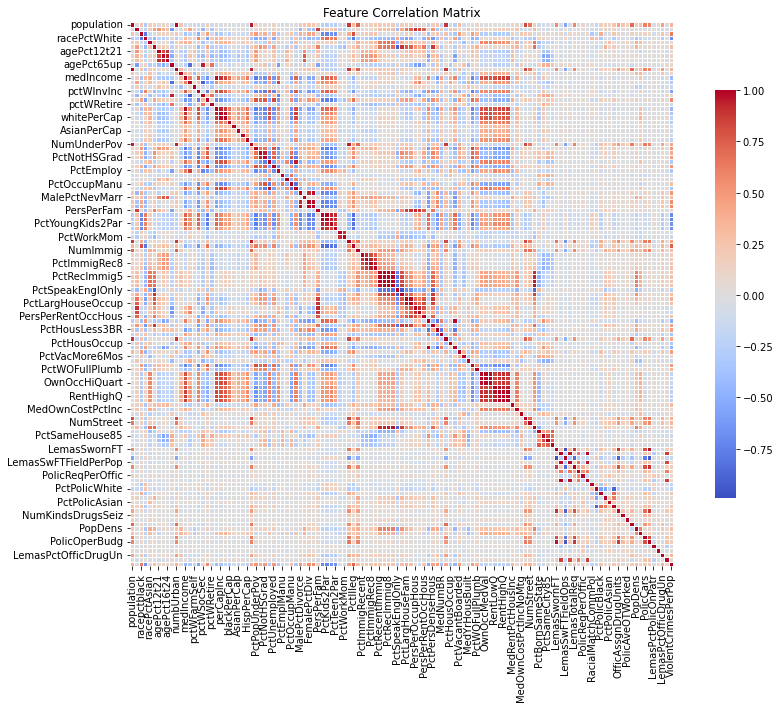

In [8]:
# Compute the correlation matrix
corr = data_communities_imputed.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.75})

# Display the plot
plt.title("Feature Correlation Matrix")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [9]:
# Calculate the sample standard deviation
s = data_communities_imputed.std()

# Calculate the sample mean
m = data_communities_imputed.mean()

# Compute CV
cv = s / m

# Display CV for each feature
print(cv)

population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
LemasPctPolicOnPatr    0.122331
LemasGangUnitDeploy    0.368040
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.337281
ViolentCrimesPerPop    0.979015
Length: 123, dtype: float64


### (e) Scatter plots and box plots for highest CV features

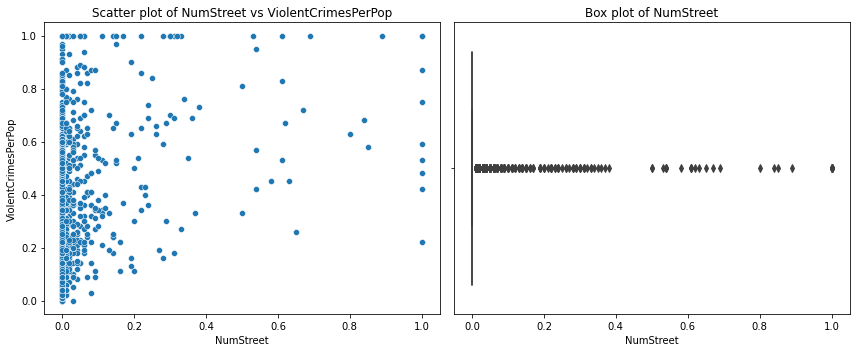

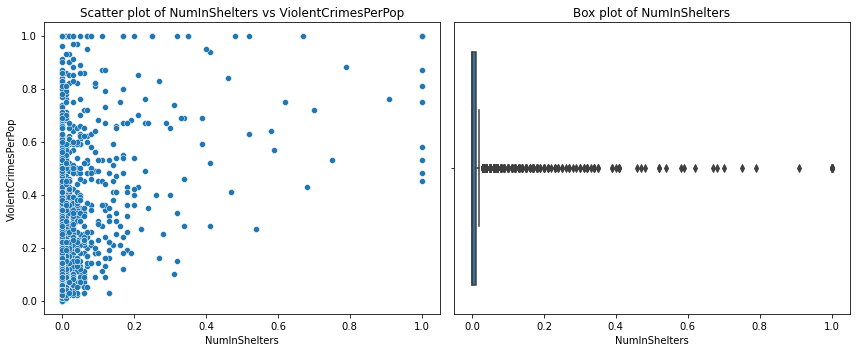

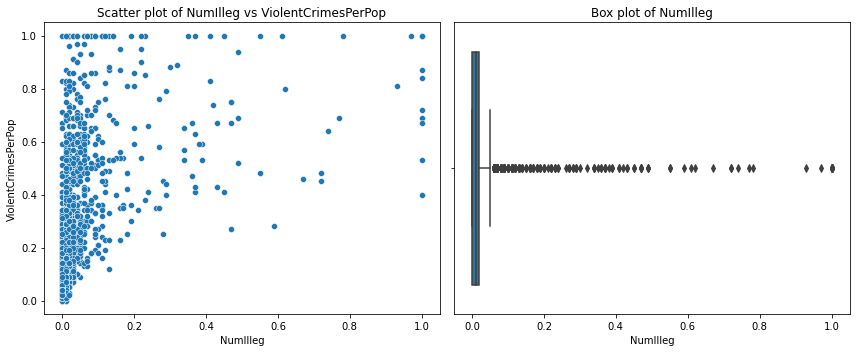

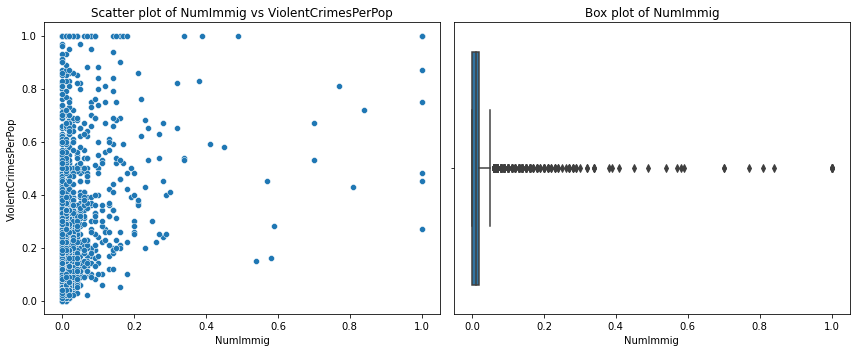

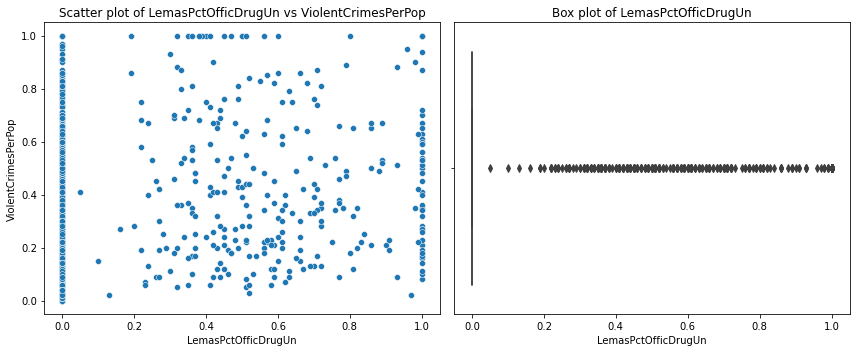

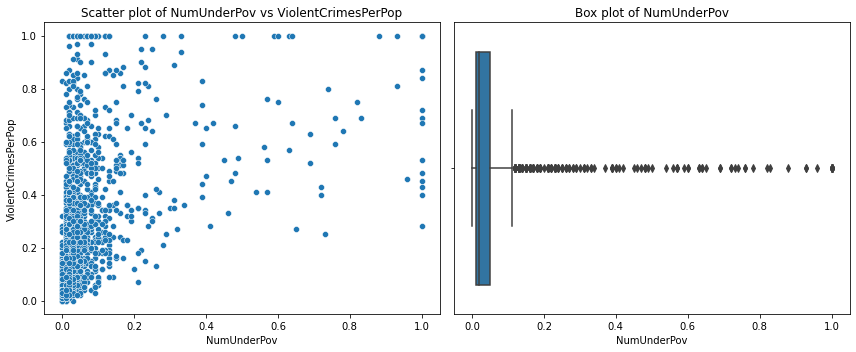

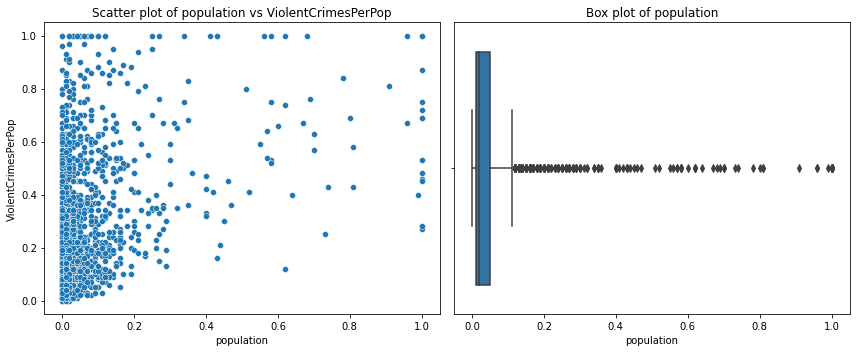

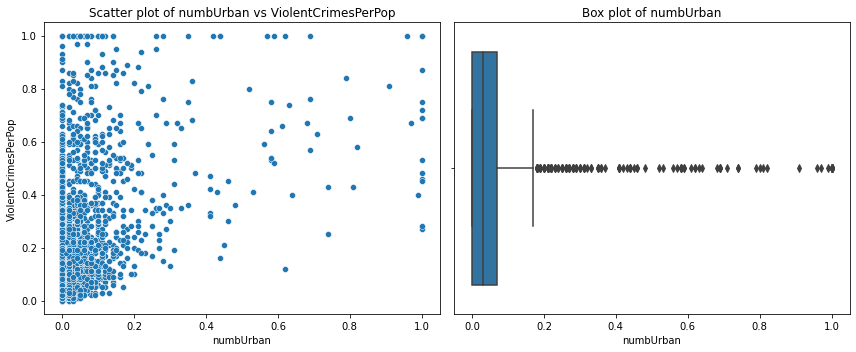

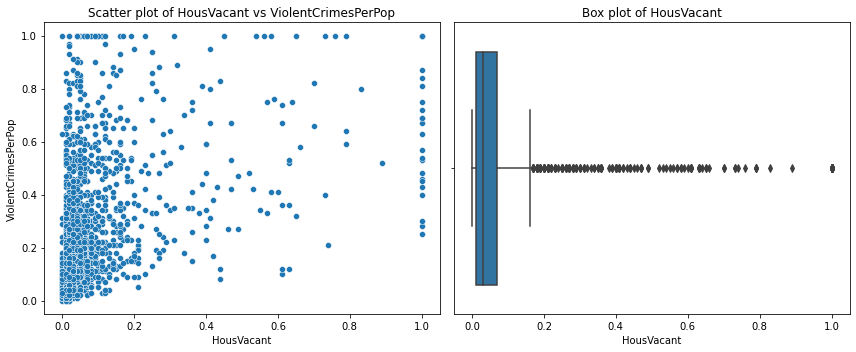

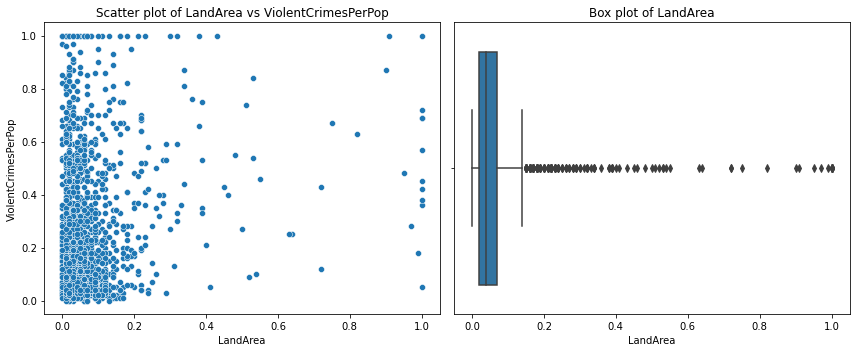

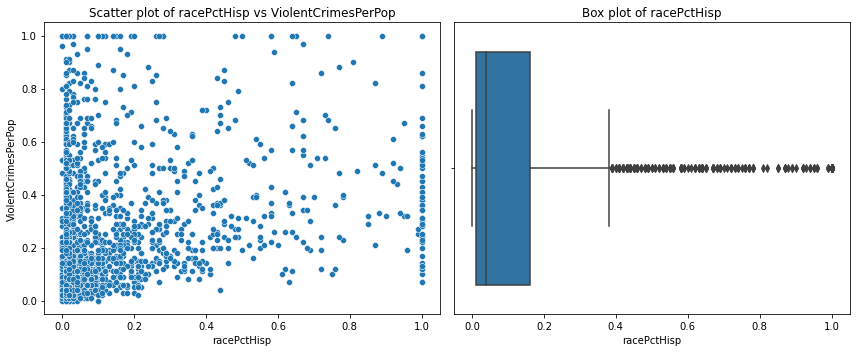

In [10]:
num_features = int(np.floor(np.sqrt(128)))

# Select the top features based on CV
top_features = cv.nlargest(num_features).index

# Scatter plots and Box plots for the top features
for feature in top_features:
    plt.figure(figsize=(12, 5))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=data_communities_imputed, x=feature, y='ViolentCrimesPerPop')
    plt.title(f'Scatter plot of {feature} vs ViolentCrimesPerPop')
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data_communities_imputed, x=feature)
    plt.title(f'Box plot of {feature}')
    
    plt.tight_layout()
    plt.show()

### (f) Fit a linear model

In [11]:
# Split the data into training and testing sets (80% train, 20% test)
X = data_communities_imputed.drop(columns=['ViolentCrimesPerPop'])
y = data_communities_imputed['ViolentCrimesPerPop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Compute the test error (Mean Squared Error, MSE)
test_error = mean_squared_error(y_test, y_pred)
print(f"Test Error (MSE): {test_error}")

Test Error (MSE): 2.1456989818731658


### (g) Fit a ridge regression model

In [12]:
# Define a set of alpha values to try for Ridge regression
alphas = np.logspace(-6, 6, 13)

# Fit Ridge regression with cross-validation to find best alpha
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Predict on the test set using the Ridge model with best alpha
y_pred_ridge = ridge_cv.predict(X_test)

# Compute the test error (Mean Squared Error, MSE) for the Ridge regression
test_error_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Optimal alpha (λ) chosen by cross-validation: {ridge_cv.alpha_}")
print(f"Test Error (MSE) for Ridge Regression: {test_error_ridge}")

# theta = ridge_model.coef_
# b = ridge_model.intercept_
# y_pred = X_test.dot(theta) + b
# # Retrieve coefficients and intercept
# theta = ridge_model.coef_
# b = ridge_model.intercept_

# # Compute predictions for the test data
# y_pred = X_test.dot(theta) + b

# # Printing out some of the predictions for clarity
# print(y_pred[:10])  # printing the first 10 predictions as an example

Optimal alpha (λ) chosen by cross-validation: 1.0
Test Error (MSE) for Ridge Regression: 0.017680173829371235


### (h) Fit a LASSO model

In [13]:
# Fit LASSO model with cross-validation to select optimal lambda (alpha)
lasso = LassoCV(cv=10).fit(X_train, y_train)

# Predict on the test set
y_pred_lasso = lasso.predict(X_test)

# Calculate the test error
test_error_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Test Error (MSE) for LASSO Regression: {test_error_lasso}")

# Variables selected by the model
selected_features_lasso = X_train.columns[lasso.coef_ != 0]
print(f"Features selected by LASSO: {selected_features_lasso}")

Test Error (MSE) for LASSO Regression: 0.017215986379628588
Features selected by LASSO: Index(['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban',
       'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWRetire',
       'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap',
       'PctPopUnderPov', 'PctLess9thGrade', 'PctUnemployed', 'PctEmplManu',
       'MalePctDivorce', 'MalePctNevMarr', 'PctKids2Par', 'PctYoungKids2Par',
       'PctWorkMom', 'NumIlleg', 'PctIlleg', 'PctImmigRec5', 'PctRecImmig8',
       'PctPersOwnOccup', 'PctPersDenseHous', 'MedNumBR', 'HousVacant',
       'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'PctHousNoPhone',
       'PctWOFullPlumb', 'RentLowQ', 'MedRent', 'MedRentPctHousInc',
       'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn', 'PctSameCity85',
       'PctSameState85', 'PolicReqPerOffic', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicAsian', 'PolicAveOTWorked',
       'LemasGangUnitDeploy', 'LemasPc

### Standardized Feature

In [14]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Fit LASSO model with cross-validation to select optimal lambda (alpha)
lasso_standardized = LassoCV(cv=10).fit(X_train_standardized, y_train)

# Predict on the test set
y_pred_lasso_standardized = lasso_standardized.predict(X_test_standardized)

# Calculate the test error
test_error_lasso_standardized = mean_squared_error(y_test, y_pred_lasso_standardized)
print(f"Test Error (MSE) for LASSO Regression on standardized features: {test_error_lasso_standardized}")

# Variables selected by the model
selected_features_lasso_standardized = X_train.columns[lasso_standardized.coef_ != 0]
print(f"Features selected by LASSO on standardized features: {selected_features_lasso_standardized}")

Test Error (MSE) for LASSO Regression on standardized features: 0.01733220231255553
Features selected by LASSO on standardized features: Index(['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban', 'pctWInvInc',
       'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctEmplManu',
       'MalePctDivorce', 'PctKids2Par', 'PctYoungKids2Par', 'PctWorkMom',
       'PctIlleg', 'PctPersDenseHous', 'HousVacant', 'PctHousOccup',
       'PctVacantBoarded', 'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg',
       'NumStreet', 'PctForeignBorn', 'PctSameCity85', 'LemasSwornFT',
       'PolicReqPerOffic', 'RacialMatchCommPol', 'PctPolicWhite',
       'PctPolicBlack', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn'],
      dtype='object')


### since the dataset is already normalized, so the error is the same if I repeat the normalization process again

### (i) Fit a PCR model

In [15]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
# Calculate MSE for each component
mse = []
for n in range(1, X_train_pca.shape[1] + 1):
    reg = LinearRegression()
    scores = cross_val_score(reg, X_train_pca[:, :n], y_train, scoring='neg_mean_squared_error', cv=10)
    mse.append(-scores.mean())

# Find the optimal number of components
M_optimal = np.argmin(mse) + 1
print(f"Optimal number of components: {M_optimal}")

reg_pcr = LinearRegression().fit(X_train_pca[:, :M_optimal], y_train)

# Transform the test set with PCA
X_test_pca = pca.transform(X_test)

# Predict on the test set
y_pred_pcr = reg_pcr.predict(X_test_pca[:, :M_optimal])

# Calculate the test error
test_error_pcr = mean_squared_error(y_test, y_pred_pcr)
print(f"Test Error (MSE) for PCR: {test_error_pcr}")

Optimal number of components: 97
Test Error (MSE) for PCR: 0.01803626126537551


### (j) Fit a boosting tree

In [16]:
param_grid = {
    'reg_alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
}
# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# GridSearchCV to find optimal reg_alpha
grid_search = GridSearchCV(xgb_reg, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameter
best_alpha = grid_search.best_params_['reg_alpha']
print(f"Optimal reg_alpha (α): {best_alpha}")

xgb_reg_best = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=best_alpha)
xgb_reg_best.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_reg_best.predict(X_test)

# Calculate the test error
test_error_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"Test Error (MSE) for L1-penalized gradient boosting tree: {test_error_xgb}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Optimal reg_alpha (α): 1
Test Error (MSE) for L1-penalized gradient boosting tree: 0.01826625446671894
